In [1]:
import os
os.chdir('FASTShapelets_TS')
print(os.getcwd())

/Users/Corentin/Desktop/MVA 2024-2025/ML for Time Series/Project/FASTShapelets_TS


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from utils.load_data import load_data
from utils.plot import plot_ecg_time_series
from draft.sax_representation import sax, sax_for_set, filtered_sax_for_set, plot_sax_with_breakpoints
from tqdm import tqdm
import time

# Chargement des données 

In [3]:
X_train, y_train = load_data(type="TRAIN")
X_test, y_test = load_data(type="TEST")

scaler = StandardScaler()
X_train_scaled = [scaler.fit_transform(x_train.reshape(-1, 1)).flatten() for x_train in X_train]
X_test_scaled = [scaler.fit_transform(x_test.reshape(-1, 1)).flatten() for x_test in X_test]

X_TRAIN shape (23, 136)
X_TEST shape (861, 136)


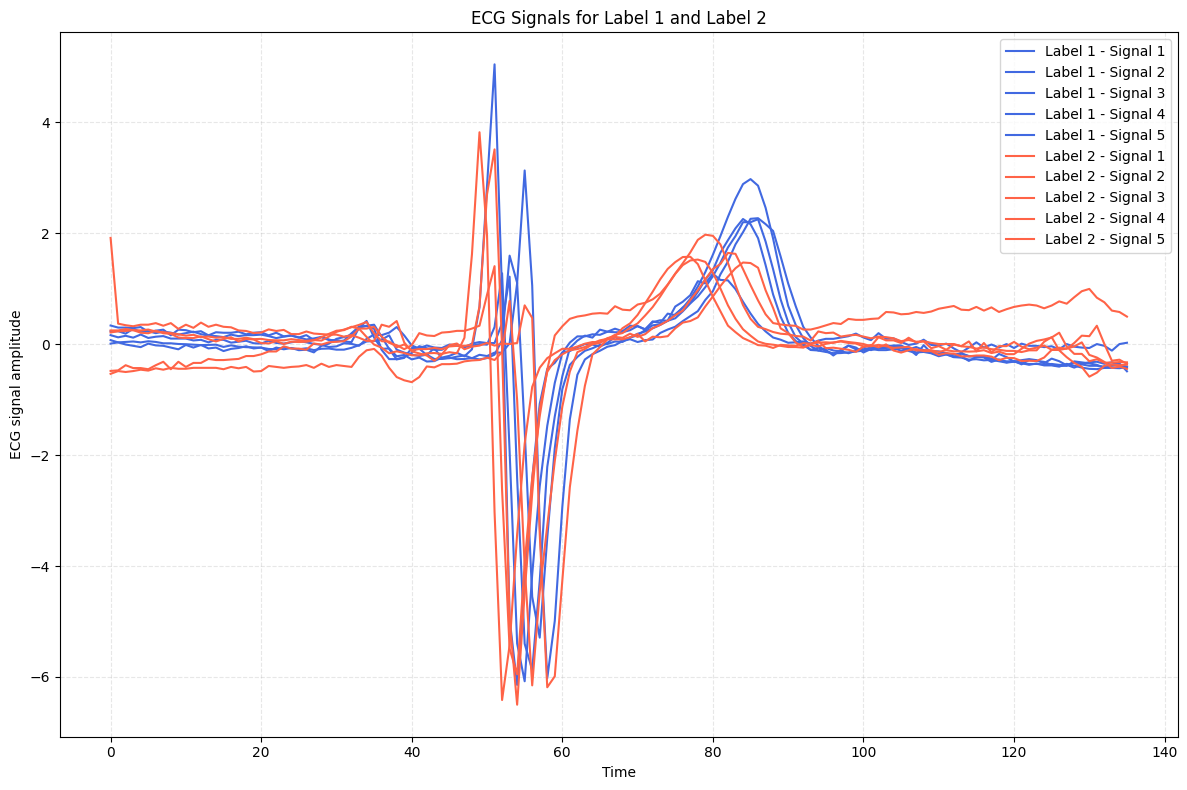

In [4]:
plot_ecg_time_series(X_train_scaled, y_train, num_series_per_class=5)


# Symbolic Aggregate approXimation (SAX): 1st method to visualize : dividing the signals into windows 
### We won't use it later 

In [6]:
# params
len_window = 17  # nb de points par fenêtre ==> length subsequence
dim_window = 4 # nouvelle dimension : taille des mots
alphabet_size = 4  # taille de l'alphabet (nombre de symboles)
stride = 1  # chevauchement (si =1, 2 windows successives on un chevauchement de len_window - 1) 

sax_results = sax_for_set(X_train_scaled, len_window, dim_window, alphabet_size, stride)

In [7]:
filtered_sax_results = filtered_sax_for_set(X_train_scaled, len_window, dim_window, alphabet_size, stride)

In [8]:
print(len(sax_results[0]))
print(len(filtered_sax_results[0]))

120
37


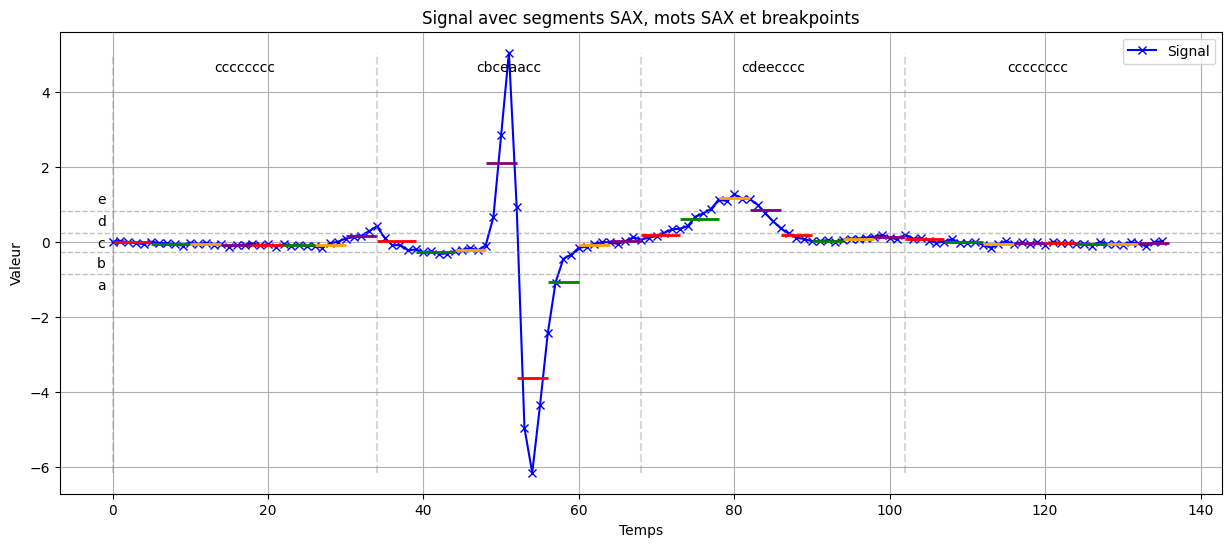

In [9]:
# Exemple SAX SANS CHEVAUCHEMENT 
signal = X_train_scaled[0]

len_window = 34
dim_window = 8 # nouvelle dimension
alphabet_size = 5
stride = 34 # pas de chevauchement pour une meilleure visibilité

# Générer les mots SAX
sax_words, windows, breakpoints = sax(signal, len_window, dim_window, alphabet_size, stride)
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g'][:alphabet_size]

# Afficher le signal et les valeurs SAX
plot_sax_with_breakpoints(signal, sax_words, windows, len_window, dim_window, stride, breakpoints, alphabet)


# Symbolic Aggregate approXimation (SAX): 2nd method using the sliding window technique


In [10]:
from utils.sax_representations_bruteforce import sax_bf, sax_for_set_bf, filtered_sax_for_set_bf

In [11]:
# params
subsequence_length = 34
word_length = 5 
alphabet_size = 4

sax_results, all_subsequences  = sax_for_set_bf(X_train_scaled, subsequence_length, word_length, alphabet_size)

# renvoie les différents SAX word pour chaque signal ainsi que la liste des "vrais" signaux correspondants 
filtered_sax_results, filtered_all_subsequences = filtered_sax_for_set_bf(X_train_scaled, subsequence_length, word_length, alphabet_size)

In [12]:
print(len(sax_results[0]))
print(len(filtered_sax_results[0]))

102
47


# Random projection and hashing 

In [13]:
from utils.sax_representations_bruteforce import sax_bf, sax_for_set_bf, filtered_sax_for_set_bf

# params
subsequence_length = 20
word_length = 10
alphabet_size = 4

sax_results, all_subsequences  = sax_for_set_bf(X_train_scaled, subsequence_length, word_length, alphabet_size)

# renvoie les différents SAX word pour chaque signal ainsi que la liste des "vrais" signaux correspondants 
filtered_sax_results, filtered_all_subsequences = filtered_sax_for_set_bf(X_train_scaled, subsequence_length, word_length, alphabet_size)

dict_sax = {i: liste for i, liste in enumerate(filtered_sax_results)}
dict_ts = {i: liste for i, liste in enumerate(filtered_all_subsequences)}

In [14]:
from utils.random_mask import compute_collision_matrix, compute_distinguish_power, find_top_k, remap_SAX_to_TS, SAX_to_TS

In [15]:
nb_iterations = 10
mots, collision_matrix = compute_collision_matrix(nb_iterations, dict_sax)

In [16]:
distinguish_power = compute_distinguish_power(nb_iterations, collision_matrix, y_train)
top_k = find_top_k(distinguish_power,mots,k=10)

In [17]:
top_k

['ccdccccdcd',
 'cccccbaaac',
 'cccccdaaaa',
 'ccccdaaaac',
 'ccccccaaab',
 'ccccdaaabc',
 'cccccdaaab',
 'bcccccbaaa',
 'ccbcccccba',
 'ccbcccccda']

In [18]:
sax_to_ts_dict = SAX_to_TS(filtered_sax_results, filtered_all_subsequences)
top_k_TS = remap_SAX_to_TS(top_k, sax_to_ts_dict)

# Fast Shapelet: main

In [2]:
import os
os.chdir('FASTShapelets_TS')
print(os.getcwd())

/Users/Corentin/Desktop/MVA 2024-2025/ML for Time Series/Project/FASTShapelets_TS


In [5]:
from utils.load_data import load_data
from sklearn.preprocessing import StandardScaler
from utils.main_fast_shapelet import main_fast_shapelets
from utils.eval import create_dataframe, create_decision_tree
from utils.plot import plot_decision_tree, plot_shapelet

In [4]:
# Load data 
X_train, y_train = load_data(type="TRAIN")
X_test, y_test = load_data(type="TEST")

scaler = StandardScaler()
X_train_scaled = [scaler.fit_transform(x_train.reshape(-1, 1)).flatten() for x_train in X_train]
X_test_scaled = [scaler.fit_transform(x_test.reshape(-1, 1)).flatten() for x_test in X_test]

X_TRAIN shape (23, 136)
X_TEST shape (861, 136)


In [8]:
# Compute Fast Shapelets
# params
X = X_train_scaled
y = y_train
min_length=20
max_length=100
dimensionality=5
cardinality=4
r=10
k=10
metric='eucl'

final_shapelets, final_shapelets_max_gain, final_shapelets_min_gap = main_fast_shapelets(X_train_scaled, y_train, min_length=min_length, max_length=max_length, dimensionality=dimensionality, cardinality=cardinality, r=r, k=k, metric=metric)

100%|██████████| 80/80 [00:08<00:00,  9.37it/s]


In [9]:
shapelets_dict = final_shapelets
metric = "eucl"
df_train = create_dataframe(X_train_scaled, shapelets_dict, metric=metric)
df_test = create_dataframe(X_test_scaled, shapelets_dict, metric=metric)

100%|██████████| 861/861 [00:00<00:00, 1562.18it/s]


In [10]:
max_depth = 1
model, report = create_decision_tree(df_train, y_train, df_test, y_test, max_depth=max_depth)
print(report)

Accuracy sur le train : 1.0000
Accuracy sur le test : 0.9501
              precision    recall  f1-score   support

    Classe 1       0.92      0.99      0.95       428
    Classe 2       0.99      0.91      0.95       433

    accuracy                           0.95       861
   macro avg       0.95      0.95      0.95       861
weighted avg       0.95      0.95      0.95       861



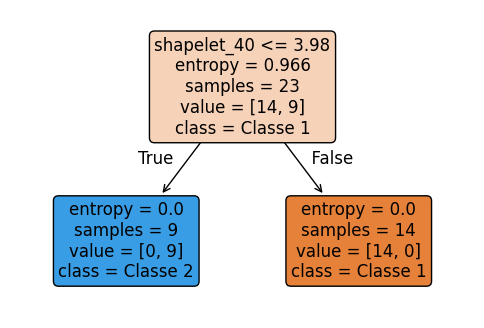

In [11]:
plot_decision_tree(model, df_train.columns.drop("Signal_nb"))

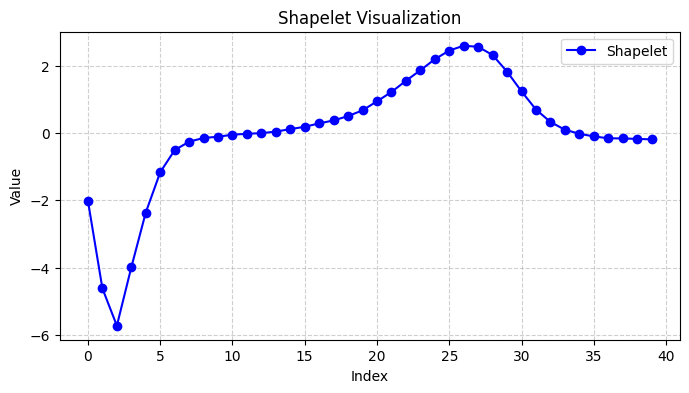

In [12]:
plot_shapelet(shapelets_dict[40])

# Test with different parameters

In [12]:
# Compute Fast Shapelets
# params
X = X_train_scaled
y = y_train
min_length=20
max_length=80
dimensionality=5
cardinality=4
r=10
k=10
metric='eucl'

final_shapelets, final_shapelets_max_gain, final_shapelets_min_gap = main_fast_shapelets(X_train_scaled, y_train, min_length=min_length, max_length=max_length, dimensionality=dimensionality, cardinality=cardinality, r=r, k=k, metric=metric)

100%|██████████| 60/60 [00:03<00:00, 17.37it/s]


In [13]:
shapelets_dict = final_shapelets

# metric = "dtw"
df_train = create_dataframe(X_train_scaled, shapelets_dict, metric=metric)
df_test = create_dataframe(X_test_scaled, shapelets_dict, metric=metric)

100%|██████████| 861/861 [00:00<00:00, 3265.52it/s]


In [14]:
max_depth = 1
model, report = create_decision_tree(df_train, y_train, df_test, y_test, max_depth=max_depth)
print(report)

Accuracy sur le train : 1.0000
Accuracy sur le test : 0.9977
              precision    recall  f1-score   support

    Classe 1       1.00      1.00      1.00       428
    Classe 2       1.00      1.00      1.00       433

    accuracy                           1.00       861
   macro avg       1.00      1.00      1.00       861
weighted avg       1.00      1.00      1.00       861



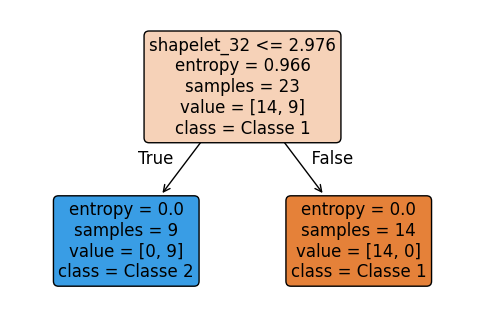

In [15]:
plot_decision_tree(model, df_train.columns.drop("Signal_nb"))

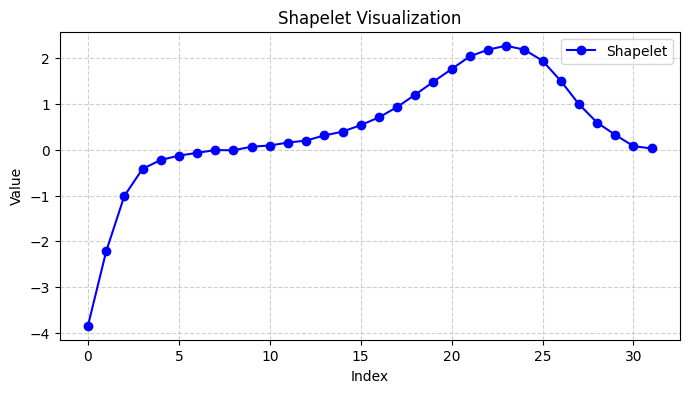

In [16]:
plot_shapelet(shapelets_dict[32]) #33, 52

# Comparison with Shapelet brute force 
### Beaucoup beaucoup plus long 

In [6]:
from utils.shapelet_bruteforce import main_shapelets_bf

In [21]:
# Load data 
X_train, y_train = load_data(type="TRAIN")
X_test, y_test = load_data(type="TEST")

scaler = StandardScaler()
X_train_scaled = [scaler.fit_transform(x_train.reshape(-1, 1)).flatten() for x_train in X_train]
X_test_scaled = [scaler.fit_transform(x_test.reshape(-1, 1)).flatten() for x_test in X_test]

X_TRAIN shape (23, 136)
X_TEST shape (861, 136)


### 40 sec pour calculer 1 seul shapelet !!! 

In [22]:
min_length = 32
max_length = 33
final_shapelets, max_gain_shapelets, min_gap_shapelets = main_shapelets_bf(X_train_scaled, y_train, min_length=min_length, max_length=max_length, metric='eucl')

100%|██████████| 1/1 [00:44<00:00, 44.83s/it]


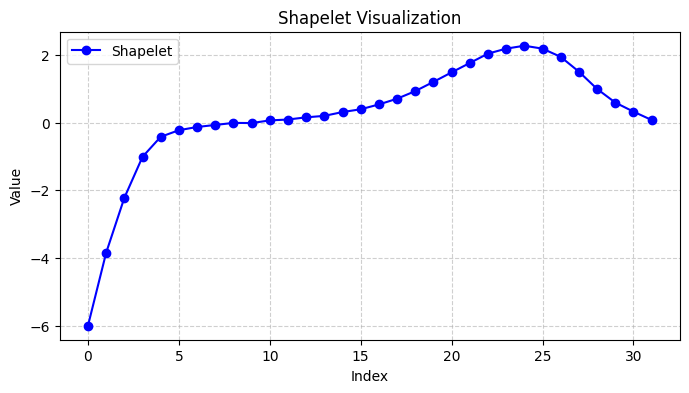

In [25]:
plot_shapelet(final_shapelets[min_length])

# Comparison with 1 Nearest Neighbor
### Faster but 0.80 of accuracy: normalized euclidean distance 

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

X_train, y_train = load_data(type="TRAIN")
X_test, y_test = load_data(type="TEST")

# standardize the data
scaler = StandardScaler()
X_train_scaled = [scaler.fit_transform(x_train.reshape(-1, 1)).flatten() for x_train in X_train]
X_test_scaled = [scaler.fit_transform(x_test.reshape(-1, 1)).flatten() for x_test in X_test]

# flatten the list of samples into 2D arrays 
X_train_flat = [x.flatten() for x in X_train_scaled]
X_test_flat = [x.flatten() for x in X_test_scaled]

# training
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_flat, y_train)

# prediction
y_pred = knn.predict(X_test_flat)

# evaluation 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))

X_TRAIN shape (23, 136)
X_TEST shape (861, 136)
Accuracy: 0.80
              precision    recall  f1-score   support

           1       0.74      0.92      0.82       428
           2       0.89      0.68      0.77       433

    accuracy                           0.80       861
   macro avg       0.81      0.80      0.79       861
weighted avg       0.82      0.80      0.79       861



In [17]:
## Approximately 9/10 min to compute 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from dtaidistance import dtw

X_train, y_train = load_data(type="TRAIN")
X_test, y_test = load_data(type="TEST")

# standardize the data
scaler = StandardScaler()
X_train_scaled = [scaler.fit_transform(x_train.reshape(-1, 1)).flatten() for x_train in X_train]
X_test_scaled = [scaler.fit_transform(x_test.reshape(-1, 1)).flatten() for x_test in X_test]

# flatten the list of samples into 2D arrays 
X_train_flat = [x.flatten() for x in X_train_scaled]
X_test_flat = [x.flatten() for x in X_test_scaled]

# Fonction personnalisée pour DTW
def dtw_distance(x, y):
    return dtw.distance(x, y)

# Créer le modèle avec une métrique personnalisée
knn_dtw = KNeighborsClassifier(n_neighbors=1, metric=dtw_distance)
knn_dtw.fit(X_train_scaled, y_train)
y_pred_dtw = knn_dtw.predict(X_test_scaled)

# Evaluation for DTW
accuracy_dtw = accuracy_score(y_test, y_pred_dtw)
print(f"Accuracy (DTW): {accuracy_dtw:.2f}")
print(classification_report(y_test, y_pred_dtw))

X_TRAIN shape (23, 136)
X_TEST shape (861, 136)
Accuracy (DTW): 0.77
              precision    recall  f1-score   support

           1       0.71      0.91      0.80       428
           2       0.87      0.63      0.73       433

    accuracy                           0.77       861
   macro avg       0.79      0.77      0.76       861
weighted avg       0.79      0.77      0.76       861



# Stability: 
- influence of dimensionality 
- influence of cardinality
- k,r 
- metric: "dtw"

In [7]:
def plot_parameters(param, list_values, accuracies, times):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel(param)
    ax1.set_ylabel('Execution Time (s)', color='tab:red')
    ax1.plot(list_values, times, label='Execution Time', color='tab:red', marker='o')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(list_values, accuracies, label='Accuracy', color='tab:blue', marker='o')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title(f'Execution Time and Accuracy vs {param}')
    fig.tight_layout()  
    plt.grid(alpha=0.5, linestyle="--")
    plt.show()

In [16]:
# INFLUENCE OF Dimensionality 
# # params
X = X_train_scaled
y = y_train
min_length=20
max_length=50
dimensionality=5
cardinality=4
r=10
k=10
metric='eucl'

dimensionalities = [2, 3, 4, 5, 10, 15]

accuracies = []
time_execution = []
for dimensionality in tqdm(dimensionalities): 
    accuracies_iter = []
    time_iter = []
    for _ in range(5):
        start_time = time.time()
        final_shapelets, final_shapelets_max_gain, final_shapelets_min_gap = main_fast_shapelets(X_train_scaled, y_train, min_length=min_length, max_length=max_length, dimensionality=dimensionality, cardinality=cardinality, r=r, k=k, metric=metric)
        end_time = time.time()
        shapelets_dict = final_shapelets
        df_train = create_dataframe(X_train_scaled, shapelets_dict, metric=metric)
        df_test = create_dataframe(X_test_scaled, shapelets_dict, metric=metric)
        max_depth = 1
        model, report, test_accuracy = create_decision_tree(df_train, y_train, df_test, y_test, max_depth=max_depth, experiments=True)
        accuracies_iter.append(test_accuracy)
        time_iter.append(end_time - start_time)
    accuracies.append(np.mean(accuracies_iter))
    time_execution.append(np.mean(time_iter))

100%|██████████| 6/6 [04:24<00:00, 44.10s/it]


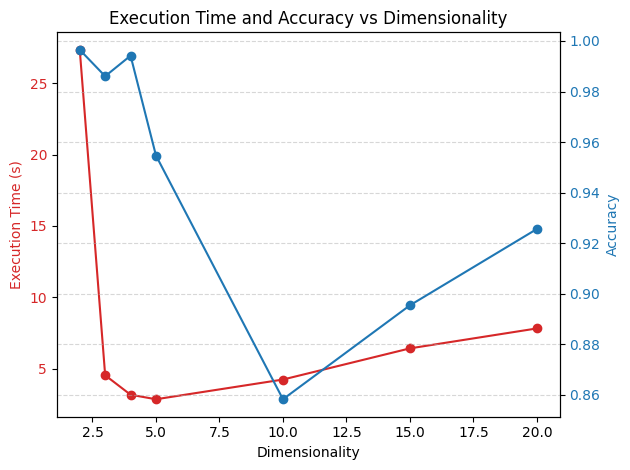

In [9]:
plot_parameters("Dimensionality", dimensionalities, accuracies, time_execution)

In [10]:
# INFLUENCE OF Cardinality 
# params
X = X_train_scaled
y = y_train
min_length=20
max_length=50
dimensionality=5
cardinality=4
r=10
k=10
metric='eucl'

cardinalities = [3, 4, 5, 6, 7]

accuracies = []
time_execution = []
for cardinality in tqdm(cardinalities): 
    accuracies_iter = []
    time_iter = []
    for _ in range(5):
        start_time = time.time()
        final_shapelets, final_shapelets_max_gain, final_shapelets_min_gap = main_fast_shapelets(X_train_scaled, y_train, min_length=min_length, max_length=max_length, dimensionality=dimensionality, cardinality=cardinality, r=r, k=k, metric=metric)
        end_time = time.time()
        shapelets_dict = final_shapelets
        df_train = create_dataframe(X_train_scaled, shapelets_dict, metric=metric)
        df_test = create_dataframe(X_test_scaled, shapelets_dict, metric=metric)
        max_depth = 1
        model, report, test_accuracy = create_decision_tree(df_train, y_train, df_test, y_test, max_depth=max_depth, experiments=True)
        accuracies_iter.append(test_accuracy)
        time_iter.append(end_time - start_time)
    accuracies.append(np.mean(accuracies_iter))
    time_execution.append(np.mean(time_iter))

100%|██████████| 5/5 [01:24<00:00, 16.95s/it]


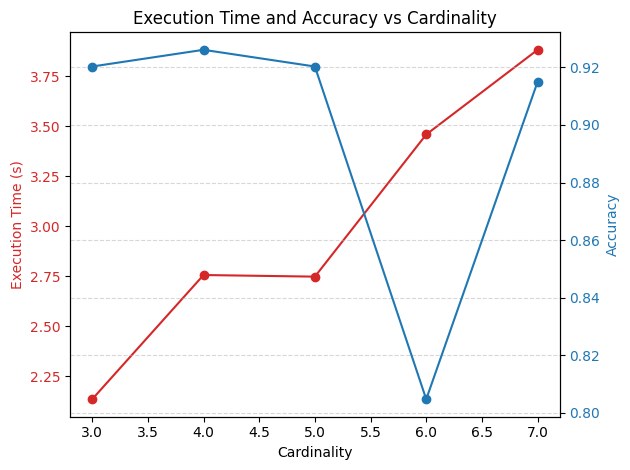

In [11]:
plot_parameters("Cardinality", cardinalities, accuracies, time_execution)

In [12]:
# INFLUENCE OF k 
# params
X = X_train_scaled
y = y_train
min_length=20
max_length=50
dimensionality=5
cardinality=4
r=10
k=10
metric='eucl'

K = [1, 5, 10, 15, 20, 50, 100]

accuracies = []
time_execution = []
for k in tqdm(K): 
    accuracies_iter = []
    time_iter = []
    for _ in range(5):
        start_time = time.time()
        final_shapelets, final_shapelets_max_gain, final_shapelets_min_gap = main_fast_shapelets(X_train_scaled, y_train, min_length=min_length, max_length=max_length, dimensionality=dimensionality, cardinality=cardinality, r=r, k=k, metric=metric)
        end_time = time.time()
        shapelets_dict = final_shapelets
        df_train = create_dataframe(X_train_scaled, shapelets_dict, metric=metric)
        df_test = create_dataframe(X_test_scaled, shapelets_dict, metric=metric)
        max_depth = 1
        model, report, test_accuracy = create_decision_tree(df_train, y_train, df_test, y_test, max_depth=max_depth, experiments=True)
        accuracies_iter.append(test_accuracy)
        time_iter.append(end_time - start_time)
    accuracies.append(np.mean(accuracies_iter))
    time_execution.append(np.mean(time_iter))

100%|██████████| 7/7 [06:18<00:00, 54.07s/it]


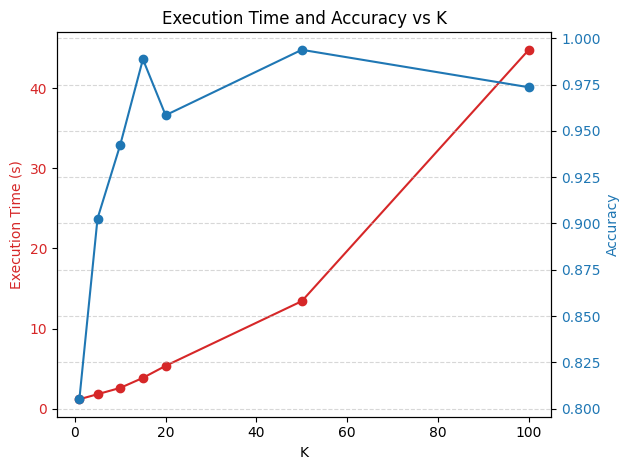

In [13]:
plot_parameters("K", K, accuracies, time_execution)

In [14]:
# INFLUENCE OF r 
# params
X = X_train_scaled
y = y_train
min_length=20
max_length=50
dimensionality=5
cardinality=4
r=10
k=10
metric='eucl'

R = [1, 5, 10, 15, 20, 50, 100]

accuracies = []
time_execution = []

for r in tqdm(R): 
    accuracies_iter = []
    time_iter = []
    for _ in range(5):
        start_time = time.time()
        final_shapelets, final_shapelets_max_gain, final_shapelets_min_gap = main_fast_shapelets(X_train_scaled, y_train, min_length=min_length, max_length=max_length, dimensionality=dimensionality, cardinality=cardinality, r=r, k=k, metric=metric)
        end_time = time.time()
        shapelets_dict = final_shapelets
        df_train = create_dataframe(X_train_scaled, shapelets_dict, metric=metric)
        df_test = create_dataframe(X_test_scaled, shapelets_dict, metric=metric)
        max_depth = 1
        model, report, test_accuracy = create_decision_tree(df_train, y_train, df_test, y_test, max_depth=max_depth, experiments=True)
        accuracies_iter.append(test_accuracy)
        time_iter.append(end_time - start_time)
    accuracies.append(np.mean(accuracies_iter))
    time_execution.append(np.mean(time_iter))

100%|██████████| 7/7 [02:33<00:00, 21.99s/it]


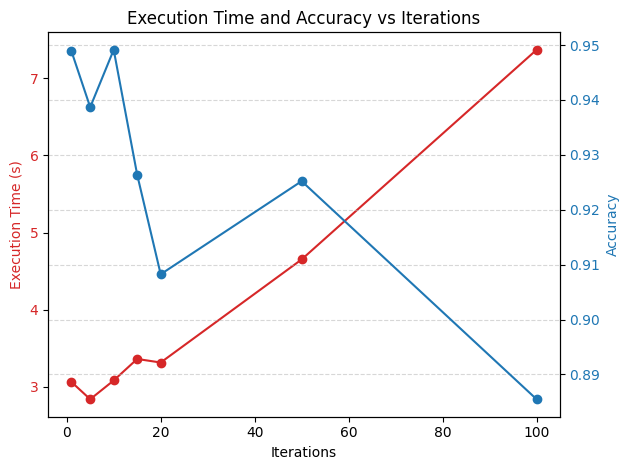

In [15]:
plot_parameters("Iterations", R, accuracies, time_execution)

# Consistency: TO DO 
- add some noise to the data 

In [71]:
# Compute Fast Shapelets
# params
sigma = 0.00001

# Ajouter du bruit gaussien aux données d'entraînement et de test
X_train_scaled_noisy = [x + np.random.normal(0, sigma, x.shape) for x in X_train_scaled]
X_test_scaled_noisy = [x + np.random.normal(0, sigma, x.shape) for x in X_test_scaled]




X = X_train_scaled
y = y_train
min_length=20
max_length=80
dimensionality=5
cardinality=4
r=10
k=10
metric='eucl'

final_shapelets, final_shapelets_max_gain, final_shapelets_min_gap = main_fast_shapelets(X_train_scaled_noisy, y_train, min_length=min_length, max_length=max_length, dimensionality=dimensionality, cardinality=cardinality, r=r, k=k, metric=metric)

100%|██████████| 60/60 [00:03<00:00, 18.52it/s]


In [72]:
shapelets_dict = final_shapelets

# metric = "dtw"
df_train = create_dataframe(X_train_scaled_noisy, shapelets_dict, metric=metric)
df_test = create_dataframe(X_test_scaled_noisy, shapelets_dict, metric=metric)
max_depth = 1
model, report = create_decision_tree(df_train, y_train, df_test, y_test, max_depth=max_depth)
print(report)

100%|██████████| 861/861 [00:00<00:00, 3268.77it/s]


Accuracy sur le train : 1.0000
Accuracy sur le test : 0.9501
              precision    recall  f1-score   support

    Classe 1       0.92      0.98      0.95       428
    Classe 2       0.98      0.92      0.95       433

    accuracy                           0.95       861
   macro avg       0.95      0.95      0.95       861
weighted avg       0.95      0.95      0.95       861

